In [21]:
import matplotlib.pyplot as plt
import scipy.io
from scipy import stats
import pandas as pd
import sklearn as sk
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import numpy as np
from numpy import linalg as LA
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Functions

In [10]:
def medias(data):
    x = []
    for i in range(len(data[1])):
        x.append(np.mean(data[:,i]))
        
    return x

def sanear(datos):
    D, V = LA.eig(datos)
    datos[datos<0] =.001
    tras = np.transpose(V)
    op = (D*V)
    ops = np.dot(op,tras)
    return ops

def clasificar(datos,clases):
    label1 = np.where(clases==1)
    label2 = np.where(clases==2)
    result1 = datos[label1[0],:]
    result2 = datos[label2[0],:]    
    
    return result1, result2
    
def lengs(data,training):
    priori = data.shape[0]/training.shape[0]       
    return priori

def QDC(data,inversa,median,san,priori):
    c= -.5
    dt = np.transpose(data)
    media_t = np.transpose(median)
    
    s1 = np.dot(data, inversa)
    sum1 = c*np.dot(s1,dt)
    
    s2 = np.dot(median, inversa)
    sum2 = np.dot(s2,dt)
    
    sum3 = c * np.dot(s2, media_t)
    
    sum4 = c * math.log(np.linalg.det(san))
    
    sum5 = math.log(priori)
    
    r = sum1+sum2+sum3+sum4+sum5   
    return r

def LDC(data,median,inversa,priori):
    c= -.5
    dt = np.transpose(data)
    media_t = np.transpose(median)
    s1 = np.dot(median,inversa)
    
    suma1 = np.dot(s1,dt)
    
    suma2 = c * np.dot(s1, media_t)
    
    suma3 = math.log(priori)
    
    r = suma1 + suma2 +suma3
    return r

def tasas(mod, cl_test):
    aciertos = []

    for ind in range(len(mod)):
        if mod[ind] == cl_test[ind]:
            aciertos.append(1)
    tasa = (sum(aciertos)/len(cl_test))*100
    return tasa

def mod_class(mod1,mod2):
    mod = []
    for j in range(len(mod1)):
        if mod1[j]> mod2[j]:
            mod.append(1)
        else:
            mod.append(2)
            
    return mod

# from file

In [11]:
mat = scipy.io.loadmat('datos_wdbc.mat')
trn = mat['trn']
clas = trn['y'][0,0]
xc = trn['xc'][0,0]
xd = trn['xd'][0,0]


#datos continuos
continuos = pd.DataFrame(data=xc)

# Training and test

In [12]:
C_train, C_test, cl_train, cl_test = train_test_split(xc, clas, test_size=.20, shuffle=False)
cov_xc = np.cov(C_train,rowvar=False)
mios = sanear(cov_xc)
clas1, clas2 = clasificar(C_train,cl_train)


# Variables

In [13]:
#medias

med_clas1 = medias(clas1)
med_clas2 = medias(clas2)

cov_clas1 = np.cov(clas1,rowvar=False)
cov_clas2 = np.cov(clas2,rowvar=False)

#saneados
san1 = sanear(cov_clas1)
san2 = sanear(cov_clas2)

#clasificaciones apriori
priori1 = lengs(clas1,C_train)
priori2 = lengs(clas2,C_train)

med_trasp_clas1 = np.transpose(med_clas1)
inv_san1 = np.linalg.inv(san1)
inv_san2 = np.linalg.inv(san1)
mios_t = np.linalg.inv(mios)

# QDC y LDC w/o regularization

In [14]:
c = -0.5
QDC1 = []
QDC2 = []
LDC1 = []
LDC2 = []

for i in range(len(C_test)):
    
    Test = C_test[i, :]
    sumaT1 = QDC(Test,inv_san1,med_clas1,san1,priori1)
    QDC1.append(sumaT1)
    sumaT2 = QDC(Test,inv_san2,med_clas2,san2,priori2)
    QDC2.append(sumaT2)
    sumaL1 = LDC(Test,med_clas1,mios_t,priori1)
    LDC1.append(sumaL1)
    sumaL2 = LDC(Test,med_clas2,mios_t,priori2)
    LDC2.append(sumaL2)


#
QDC_T = mod_class(QDC1,QDC2)
LDC_T = mod_class(LDC1,LDC2)  
      
tasa_QDC = tasas(QDC_T,cl_test)
tasa_LDC = tasas(LDC_T,cl_test)

# QDC Regularized

In [15]:
alpha = np.arange(0,1,.1)
matris = np.dot(san1,mios)

RQDC1 = []
RQDC2 = []
RQDC1_e = []
RQDC2_e = []
xi = []
RLDC1 = []
RLDC2 = []

QDCTS1 = []
QDCTS2 = []
for ap in range(len(alpha)):
    QDC_reg1 = alpha[ap] * san1 + (1 - alpha[ap]) * mios
    QDC_reg2 = alpha[ap] * san2 + (1 - alpha[ap]) * mios
    
    for i in range(len(C_test)):
        RTest = C_test[i, :]
        z1 = QDC(RTest,np.linalg.inv(QDC_reg1),med_clas1,QDC_reg1,priori1)
        QDCTS1.append(z1)
        z2= QDC(RTest,np.linalg.inv(QDC_reg2),med_clas2,QDC_reg2,priori2)
        QDCTS2.append(z2)
    
    
    RQDC1_e.append(QDCTS1)
    RQDC2_e.append(QDCTS2)
    QDCTS1 = []
    QDCTS2 = []

QDC_class = []    
QDC_tasa = []

for a in range(len(RQDC1_e)):
    clas = mod_class(RQDC1_e[a],RQDC2_e[a])
    QDC_class.append(clas)

for a in range(len(RQDC1_e)):
    tasa = tasas(QDC_class[a],cl_test)
    QDC_tasa.append(tasa)

# LDC Regularized

In [16]:
gama = np.arange(0,1,.1)
LDCTS1 = []
LDCTS2 = []

RLDC1_e = []
RLDC2_e = []  
varianza = np.cov(C_train)    
for g in range(len(gama)):
    LDC_reg = gama[g] * mios + (1 - gama[g]) * mios 
    
    for i in range(len(C_test)):
        RTest = C_test[i, :]
        z1 = LDC(RTest,med_clas1,np.linalg.inv(LDC_reg),priori1)
        LDCTS1.append(z1)
        z2 = LDC(RTest,med_clas2,np.linalg.inv(LDC_reg),priori2)
        LDCTS2.append(z2)
        
    RLDC1_e.append(LDCTS1)
    RLDC2_e.append(LDCTS2)
    LDCTS1 = []
    LDCTS2 = []

LDC_class = []    
LDC_tasa = []

for a in range(len(RLDC1_e)):
    clas2 = mod_class(RLDC1_e[a],RLDC2_e[a])
    LDC_class.append(clas2)

for a in range(len(RLDC1_e)):
    tasa2 = tasas(LDC_class[a],cl_test)
    LDC_tasa.append(tasa2)    

# Plots

[Text(0, 0.5, 'tasa'), Text(0.5, 0, 'gamma'), Text(0.5, 1.0, 'LDC')]

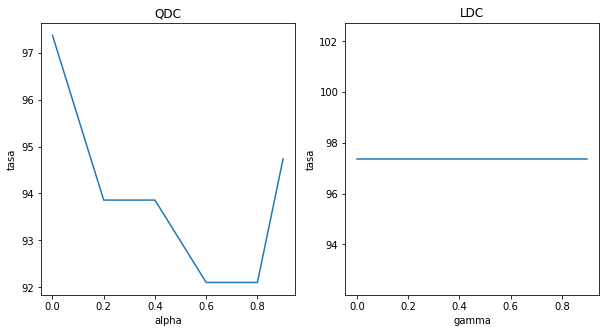

In [17]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(alpha,QDC_tasa)
ax1.set(title="QDC", xlabel="alpha", ylabel="tasa")
ax2.plot(gama,LDC_tasa)
ax2.set(title="LDC", xlabel="gamma", ylabel="tasa")

In [20]:
print("QDC \n")
print("QDC tasa de reconocimiento \n", tasa_QDC)
print("QDC tasa de reconocimiento regularizada \n", QDC_tasa)

print("\nLDC \n")
print("LDC tasa de reconocimiento \n", tasa_LDC)

QDC 

QDC tasa de reconocimiento 
 85.96491228070175
QDC tasa de reconocimiento regularizada 
 [97.36842105263158, 95.6140350877193, 93.85964912280701, 93.85964912280701, 93.85964912280701, 92.98245614035088, 92.10526315789474, 92.10526315789474, 92.10526315789474, 94.73684210526315]

LDC 

LDC tasa de reconocimiento 
 97.36842105263158
